<a href="https://colab.research.google.com/github/SeanMulherin/seanmulherin.github.io/blob/main/spx_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Pacakges

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import datetime as dt
import warnings
import yfinance as yf

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
warnings.filterwarnings('ignore')

#Data Prep

The data we will be using is generously provided by Yahoo Finance. We will look at the closing price of S&P 500 Index (SPX) for all days starting from 1990 onward. The goal is to fit a forcasting model to predict the trend.

In [ ]:
start_date = '1990-01-01'
end_date = str(dt.datetime.today().strftime("%Y-%m-%d"))
spx = yf.download(tickers = "^SPX",
                  start = start_date,
                  end = end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
spx

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,359.690002,162070000
1990-01-03,359.690002,360.589996,357.890015,358.760010,358.760010,192330000
1990-01-04,358.760010,358.760010,352.890015,355.670013,355.670013,177000000
1990-01-05,355.670013,355.670013,351.350006,352.200012,352.200012,158530000
1990-01-08,352.200012,354.239990,350.540009,353.790009,353.790009,140110000
...,...,...,...,...,...,...
2024-03-04,5130.990234,5149.669922,5127.180176,5130.950195,5130.950195,4758440000
2024-03-05,5110.520020,5114.540039,5056.819824,5078.649902,5078.649902,4418410000
2024-03-06,5108.029785,5127.970215,5092.220215,5104.759766,5104.759766,4559050000


In [ ]:
spx = spx.loc[:, ['Close']]
spx.columns = ['y']
spx.index.rename('ds', inplace=True)

In [ ]:
plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=spx,x=spx.index, y='y',color='firebrick')
sns.despine()
plt.title("The Stock Price of SPX",size='x-large',color='blue')
plt.xlabel("Date")
plt.ylabel("Price USD")

#Model

###Cross Validation

Set the cut off date to be 1 year ago from today. Use the previous year as the validaiton set to which we will compare our predictions.

In [ ]:
split_date = datetime.today() - timedelta(days = 365)

spx_train = spx.loc[spx.index <= split_date].copy()
spx_test = spx.loc[spx.index > split_date].copy()

<Axes: title={'center': 'SPX Train and Test Sets'}, xlabel='Date', ylabel='Price USD'>

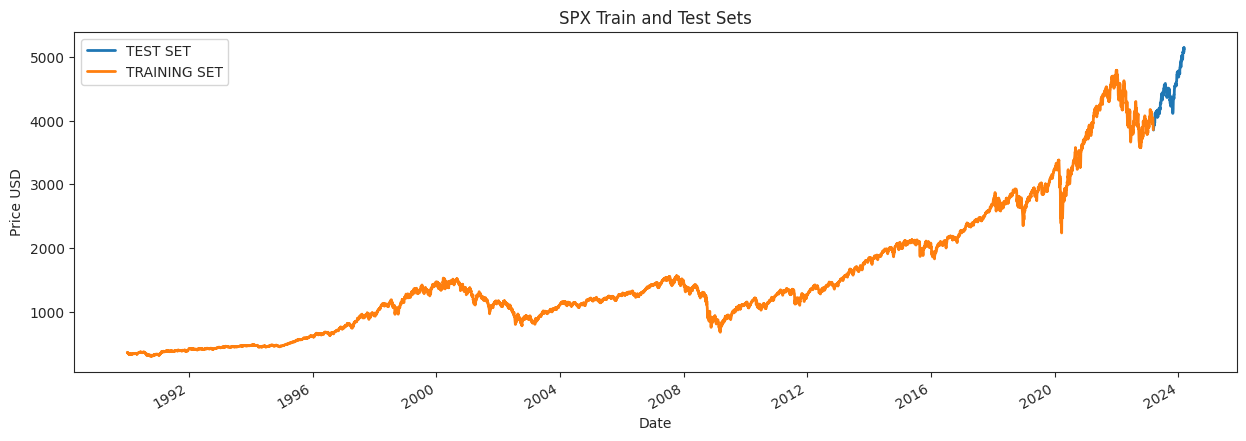

In [ ]:
spx_test = spx_test.rename(columns={'y': 'TEST SET'})
spx_train = spx_train.rename(columns={'y': 'TRAINING SET'})
joined_df = spx_test.join(spx_train, how='outer')
joined_df.plot(figsize=(15, 5),
               title='SPX Train and Test Sets',
               style='-',
               linewidth=2,
               xlabel='Date',
               ylabel='Price USD')

### Fit and Predict

Fit the FB Prophet model to training data and predict daily closing price for the next year.

In [ ]:
spx_train.reset_index(inplace=True)
spx_train.columns = ['ds', 'y']

In [ ]:
model = Prophet()
model_fit = model.fit(spx_train)
future = model_fit.make_future_dataframe(periods=365, freq='D')
future = future[future.ds.dt.dayofweek < 6]

pred = model_fit.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_7boit8w/99ctybi1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_7boit8w/vsuc1wql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5118', 'data', 'file=/tmp/tmp_7boit8w/99ctybi1.json', 'init=/tmp/tmp_7boit8w/vsuc1wql.json', 'output', 'file=/tmp/tmp_7boit8w/prophet_modelb86jt41u/prophet_model-20240311022848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:28:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:28:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1990-01-02,328.615687,157.914953,529.346446,328.615687,328.615687,7.508151,7.508151,7.508151,-5.364982,-5.364982,-5.364982,12.873133,12.873133,12.873133,0.0,0.0,0.0,336.123838
1,1990-01-03,328.709212,143.475573,527.704970,328.709212,328.709212,7.895050,7.895050,7.895050,-5.418813,-5.418813,-5.418813,13.313863,13.313863,13.313863,0.0,0.0,0.0,336.604262
2,1990-01-04,328.802737,156.390757,519.294652,328.802737,328.802737,7.913257,7.913257,7.913257,-5.710813,-5.710813,-5.710813,13.624071,13.624071,13.624071,0.0,0.0,0.0,336.715995
3,1990-01-05,328.896262,154.052648,507.708891,328.896262,328.896262,7.288699,7.288699,7.288699,-6.507100,-6.507100,-6.507100,13.795799,13.795799,13.795799,0.0,0.0,0.0,336.184961
4,1990-01-08,329.176837,152.577052,508.114094,329.176837,329.176837,7.609889,7.609889,7.609889,-5.843367,-5.843367,-5.843367,13.453257,13.453257,13.453257,0.0,0.0,0.0,336.786727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8670,2024-03-05,4762.340461,4531.695883,4952.105961,4681.085950,4823.536155,-19.261137,-19.261137,-19.261137,-5.364982,-5.364982,-5.364982,-13.896155,-13.896155,-13.896155,0.0,0.0,0.0,4743.079324
8671,2024-03-06,4763.310576,4525.915510,4939.612658,4681.010968,4824.760290,-19.850375,-19.850375,-19.850375,-5.418813,-5.418813,-5.418813,-14.431561,-14.431561,-14.431561,0.0,0.0,0.0,4743.460201
8672,2024-03-07,4764.280691,4545.130946,4944.839868,4681.794709,4825.984425,-20.487797,-20.487797,-20.487797,-5.710813,-5.710813,-5.710813,-14.776983,-14.776983,-14.776983,0.0,0.0,0.0,4743.792894
8673,2024-03-08,4765.250805,4544.426871,4957.245489,4682.689036,4827.435199,-21.440757,-21.440757,-21.440757,-6.507100,-6.507100,-6.507100,-14.933657,-14.933657,-14.933657,0.0,0.0,0.0,4743.810048


In [ ]:
final_date = pred.ds.iloc[-1].strftime("%Y-%m-%d")
print(f"The predicted price for SPX on {final_date} is ${pred.yhat.iloc[-1]:.2f}")

The predicted price for SPX on 2024-03-09 is $4765.74


### Plot

#### Prediction Model

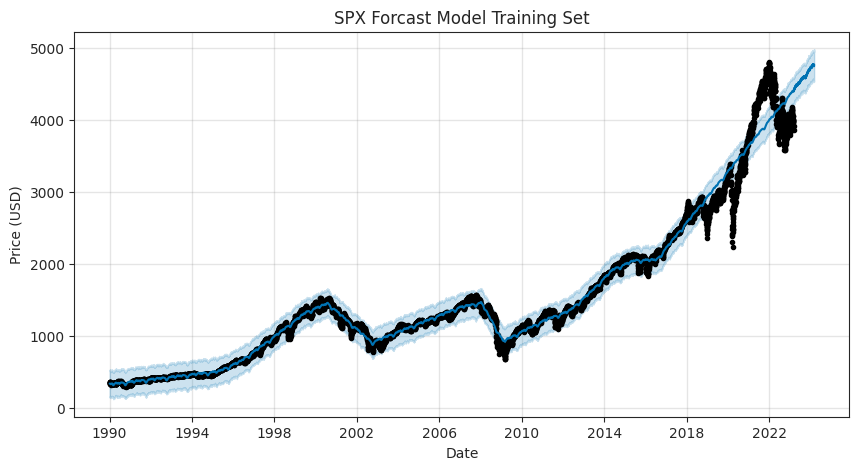

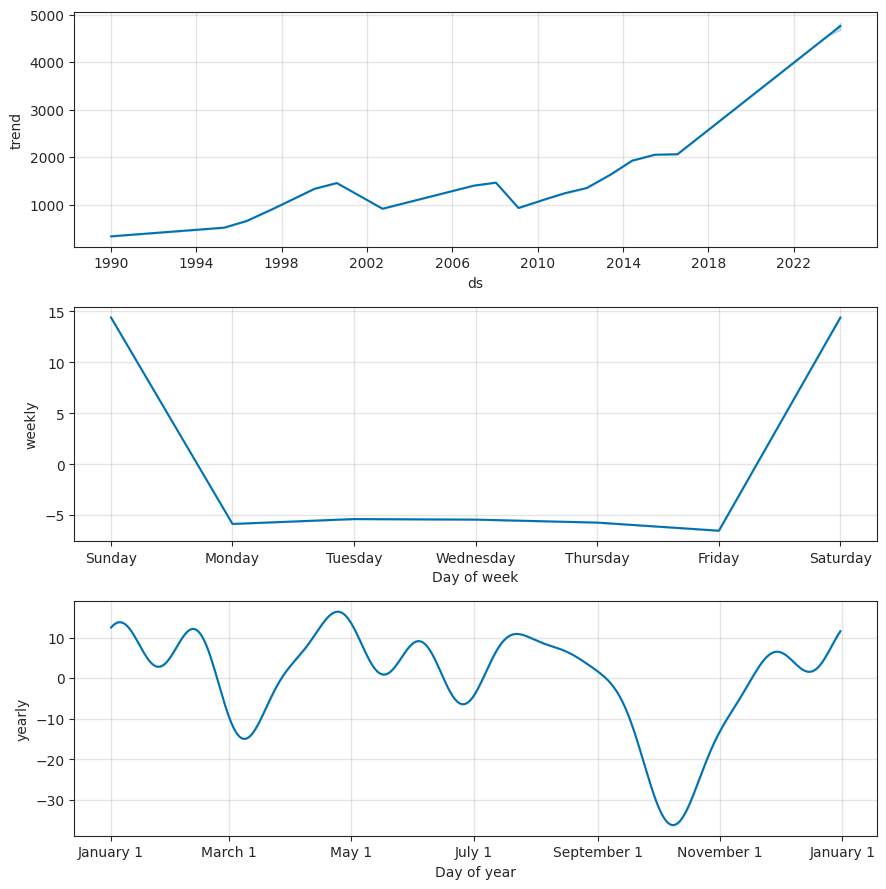

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pred, ax=ax)
ax.set_title('SPX Forcast Model Training Set')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')

fig = model.plot_components(pred)

#### Compare Predicted Prices to Actual Prices

In [ ]:
spx_test.reset_index(inplace=True)
spx_test.columns = ['ds', 'y']
spx_test_fcst = model.predict(spx_test)

Text(0, 0.5, 'Price USD')

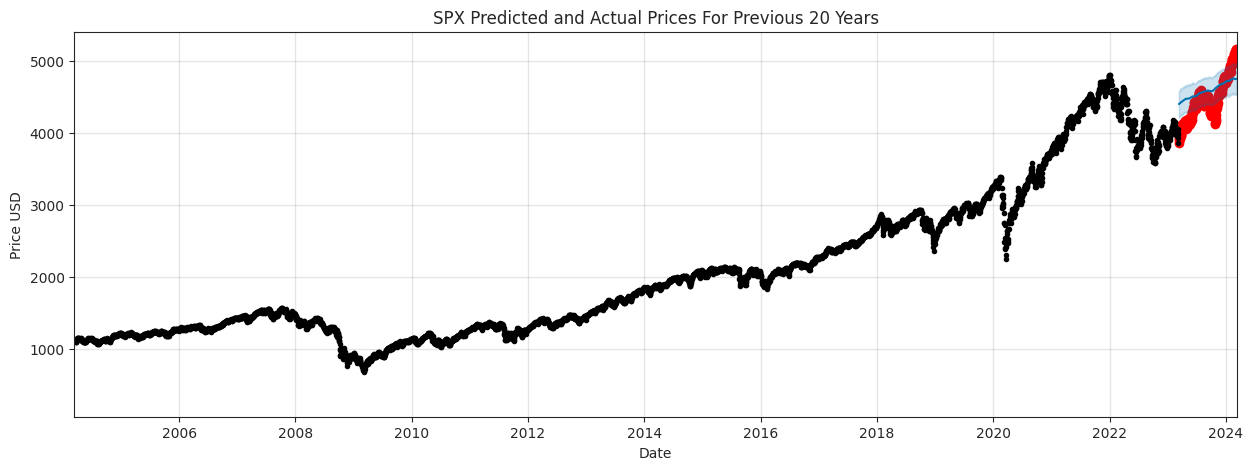

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(spx_test.ds,
           spx_test['y'],
           color='r')
fig = model.plot(spx_test_fcst, ax=ax)
ax.set_xbound(lower= pred.ds.iloc[-1] - timedelta(days=365*20),
              upper=datetime.today())
plt.title('SPX Predicted and Actual Prices For Previous 20 Years')
ax.set_xlabel('Date')
ax.set_ylabel('Price USD')

Text(0, 0.5, 'Price USD')

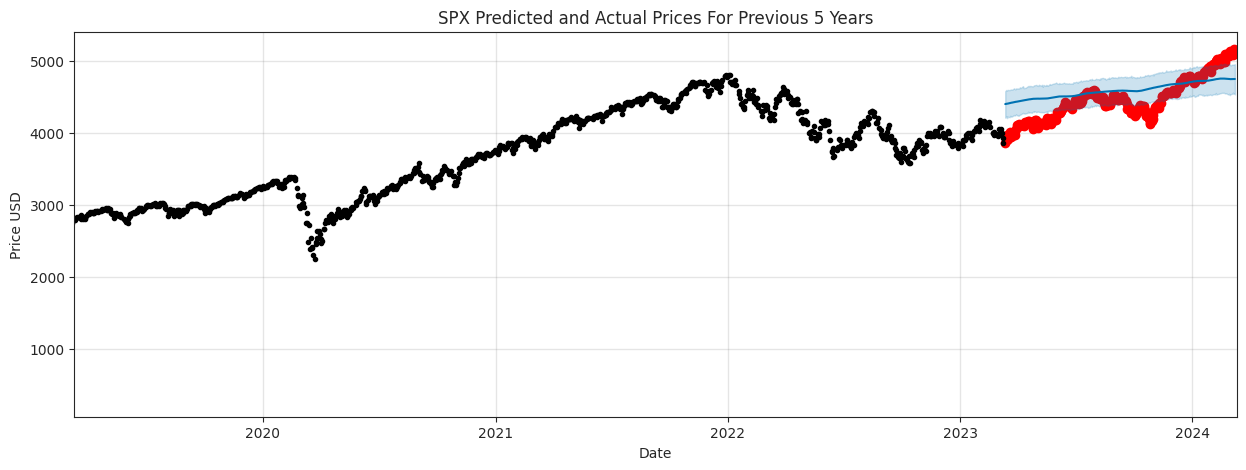

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(spx_test.ds,
           spx_test['y'],
           color='r')
fig = model.plot(spx_test_fcst, ax=ax)
ax.set_xbound(lower= pred.ds.iloc[-1] - timedelta(days=365*5),
              upper=datetime.today())
plt.title('SPX Predicted and Actual Prices For Previous 5 Years')
ax.set_xlabel('Date')
ax.set_ylabel('Price USD')

Text(0, 0.5, 'Price USD')

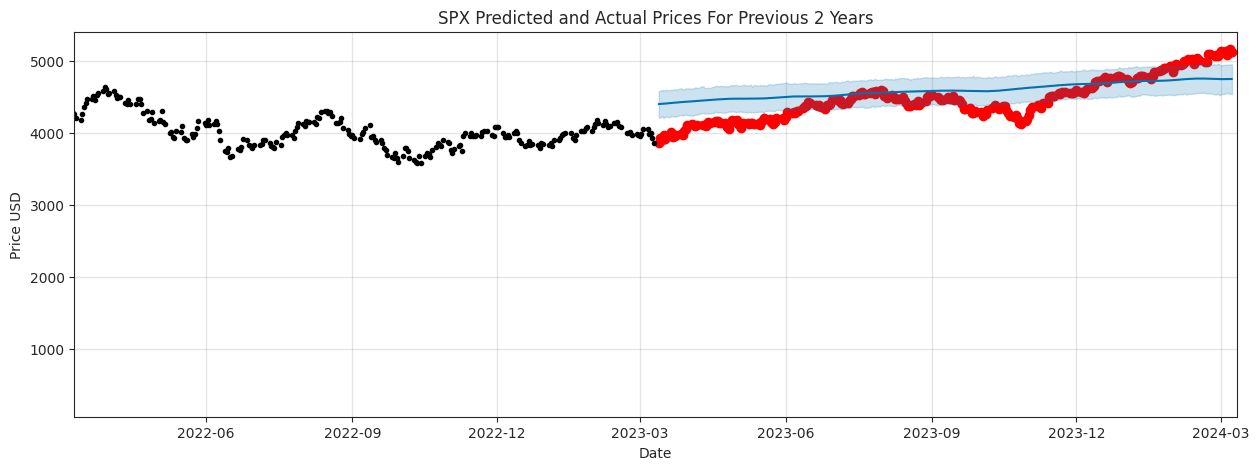

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(spx_test.ds,
           spx_test['y'],
           color='r')
fig = model.plot(spx_test_fcst, ax=ax)
ax.set_xbound(lower= pred.ds.iloc[-1] - timedelta(days=365*2),
              upper=datetime.today())
plt.title('SPX Predicted and Actual Prices For Previous 2 Years')
ax.set_xlabel('Date')
ax.set_ylabel('Price USD')

Text(0, 0.5, 'Price USD')

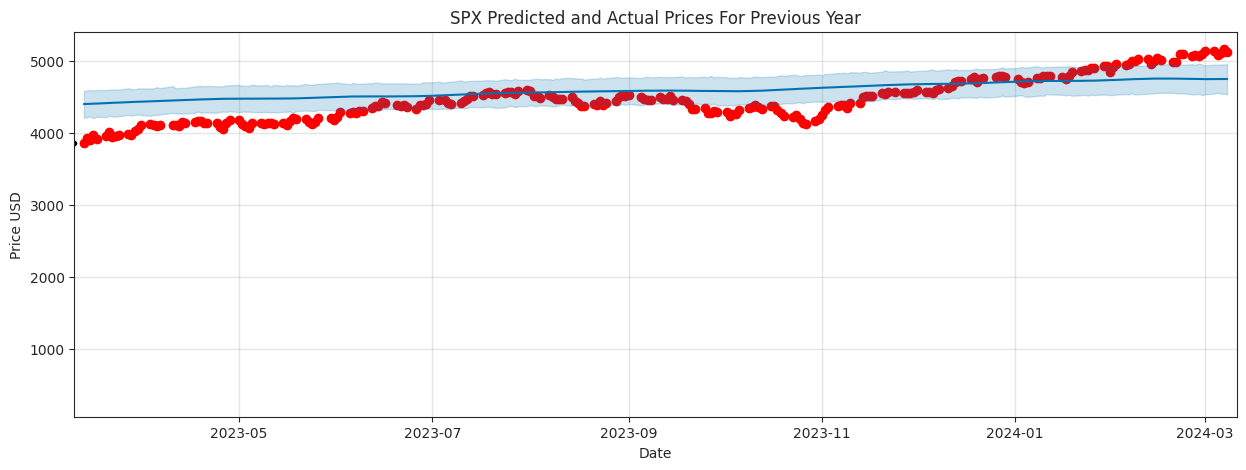

In [ ]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(spx_test.ds,
           spx_test['y'],
           color='r')
fig = model.plot(spx_test_fcst, ax=ax)
ax.set_xbound(lower= pred.ds.iloc[-1] - timedelta(days=365),
              upper=datetime.today())
plt.title('SPX Predicted and Actual Prices For Previous Year')
ax.set_xlabel('Date')
ax.set_ylabel('Price USD')

### Error Metrics


In [ ]:
mse = mean_squared_error(y_true=spx_test['y'],
                   y_pred=spx_test_fcst['yhat'])

mae = mean_absolute_error(y_true=spx_test['y'],
                   y_pred=spx_test_fcst['yhat'])

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=spx_test['y'],
                   y_pred=spx_test_fcst['yhat'])

In [ ]:
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Absolute Percent Error: {mape:.2f}%")

Mean Squared Error: 61326.11
Mean Absolute Error: 209.35
Mean Absolute Percent Error: 4.82%
